The goal of this notebook is to perform optimizations on all Microsim models of interest to the Kaiser population projects.
We start with the models that can produce death outcomes and then proceed to outcome models that are not so likely associated with mortality. These optimizations allow us to find intercept adjustments, and in the case of dementia, changes to the linear and quadratic term, so that we can have an average estimate of the increased risk to the Kaiser population but without using the CCD specific information
such as WMH severity, SBI presence or not...Important note: in the current version of the microsim code, in the ascvd model there is a line
that adds the CCD specific contribution and there is no way to use monkey patching to modify the hard coded ASCVD model (at least I could not find a solution in a reasonable amount of time). So to run this optimization notebook, the line that adds the CCD contribution to the ASCVD model needs to be commented out. And then when done of course, do not forget to uncomment that line...

In [1]:
import numpy as np
import pandas as pd
import os
import importlib.util
from scipy import optimize
import matplotlib.pyplot as plt

microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)
dataDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/NOTEBOOKS/DATA"

pd.set_option('future.no_silent_downcasting', True) 

from microsim.outcome import OutcomeType
from microsim.regression_model import RegressionModel
from microsim.modality import Modality
from microsim.population_factory import PopulationFactory
from microsim.data_loader import load_model_spec
from microsim.ascvd_outcome_model import ASCVDOutcomeModel
from microsim.dementia_model_repository import DementiaModelRepository
from microsim.dementia_model import DementiaModel
from microsim.cv_model import CVModelMale, CVModelFemale
from microsim.non_cv_death_model import NonCVDeathModel
from microsim.statsmodel_logistic_risk_factor_model import StatsModelLogisticRiskFactorModel
from microsim.outcome import Outcome, OutcomeType

In [2]:
strokeRatesRef = 12 #microsim simulation

deathRatesRef = 27 #microsim simulation

dementiaRatesRef = 11 #microsim simulation

ratesRef = {"stroke": strokeRatesRef, "death": deathRatesRef, "dementia": dementiaRatesRef, "mi": 12}

In [ ]:
def get_rates_from_models(x):
    '''This function will change as we move on to the different parts of the model optimization.'''
    
    ascvdInterceptChange = x[0]
    dementiaLinearChange = 0 #at this step we will not optimize at all dementia, we will leave it at the NHANES default
    dementiaQuadraticChange = 0 
    nonCVDeathInterceptChange = x[1]
    
    def get_scd_term(person):
            '''This is the contribution to the one year linear predictor due to the silent cerebrovascular disease (scd).'''
            scdTerm = 0
            window = len(person._age)
            severityUnknown=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverityUnknown", inSim=True),
            severity=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverity", inSim=True)
            if person._outcomes[OutcomeType.WMH][0][1].sbi:
                if person._modality == Modality.MR.value:
                    if person._age[-1] < 65:
                        if window ==1:
                            scdTerm += np.log(4.75)
                        elif window <=3:
                            scdTerm += np.log(3.45)
                        elif window <=5:
                            scdTerm += np.log(2.18)
                        elif window >5:
                            scdTerm += np.log(1.99)
                    else:
                        if window ==1:
                            scdTerm += np.log(3.)
                        elif window <=3:
                            scdTerm += np.log(2.63)
                        elif window <=5:
                            scdTerm += np.log(1.61)
                        elif window >5:
                            scdTerm += np.log(1.43)
                elif person._modality == Modality.CT.value:
                    if person._age[-1] < 65:
                        if window ==1:
                            scdTerm += np.log(3.91)
                        elif window <=3:
                            scdTerm += np.log(2.34)
                        elif window <=5:
                            scdTerm += np.log(2.33)
                        elif window >5:
                            scdTerm += np.log(2.01)
                    else:
                        if window ==1:
                            scdTerm += np.log(2.47)
                        elif window <=3:
                            scdTerm += np.log(1.79)
                        elif window <=5:
                            scdTerm += np.log(1.71)
                        elif window >5:
                            scdTerm += np.log(1.44)
            if person._outcomes[OutcomeType.WMH][0][1].wmh:
                if window ==1:
                    td = 1.
                    #        lp += np.log(1.89)
                elif window <=3:
                    #td = 1.9/1.89
                    td = np.log(1.9)/np.log(1.89)
                    #        lp += np.log(1.90)
                elif window <=5:
                    #td = 1.73/1.89
                    td = np.log(1.73)/np.log(1.89)
                    #        lp += np.log(1.73)
                elif window >5:
                    #td = 1.56/1.89
                    td = np.log(1.56)/np.log(1.89)
                    #        lp += np.log(1.56)
                td = 1 #let's see the best we can do without time dependency
                if person._modality == Modality.MR.value:
                    if severityUnknown:
                        scdTerm += np.log(td*1.89)
                    elif severity == WMHSeverity.MILD:
                        scdTerm += np.log(td*1.51)
                    elif severity == WMHSeverity.MODERATE:
                        scdTerm += np.log(td*2.33)
                    elif severity == WMHSeverity.SEVERE:
                        scdTerm += np.log(td*2.65)
                    elif severity == WMHSeverity.NO:
                        scdTerm += np.log(td*1.)
                elif person._modality == Modality.CT.value:
                    if severityUnknown:
                        scdTerm += np.log(td*2.40)
                    elif severity == WMHSeverity.MILD:
                        scdTerm += np.log(td*2.15)
                    elif severity == WMHSeverity.MODERATE:
                        scdTerm += np.log(td*3.01)
                    elif severity == WMHSeverity.SEVERE:
                        scdTerm += np.log(td*3.23)
                    elif severity == WMHSeverity.NO:
                        scdTerm += np.log(td*1.39)
            return scdTerm
    
    # these will replace the CV models that microsim uses by default
    interceptM = -11.679980 + ascvdInterceptChange
    interceptF =  -12.823110 + ascvdInterceptChange
    class CVModelMaleKaiser(CVModelMale):
        def __init__(self, intercept=interceptM):
            super().__init__(intercept = intercept)
            
        def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
            lp = super().get_one_year_linear_predictor(person, interceptChangeFor1bpMedsAdded)
            #lp += get_scd_term(person)
            return lp

    class CVModelFemaleKaiser(CVModelFemale):
        def __init__(self, intercept=interceptF):
            super().__init__(intercept = intercept)
            
        def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
            lp = super().get_one_year_linear_predictor(person, interceptChangeFor1bpMedsAdded)
            #lp += get_scd_term(person)
            return lp

    import importlib.util
    module = importlib.import_module("microsim.cv_model_repository")
    setattr(module, "CVModelMale", CVModelMaleKaiser)
    setattr(module, "CVModelFemale", CVModelFemaleKaiser)
    
    class DementiaModelRepositoryKaiser(DementiaModelRepository):
        def __init__(self):
            self._models = {"NHANES": DementiaModel(), #default linear and quadratic terms for NHANES
                            "brainScan": DementiaModel(linearTerm= 1.33371239e-05 +dementiaLinearChange, 
                                                       quadraticTerm= 5.64485841e-05 +dementiaQuadraticChange)} #had a brain scan
        
    module = importlib.import_module("microsim.outcome_model_repository")
    setattr(module, "DementiaModelRepository", DementiaModelRepositoryKaiser)
    
    class NonCVDeathModelKaiser(StatsModelLogisticRiskFactorModel):
        def __init__(self):
            modelSpec = load_model_spec("nhanesMortalityModelLogit")
            # Recalibrate mortalitly model to align with life table data, as explored in notebook buildNHANESMortalityModel
            modelSpec["coefficients"]["age"] = modelSpec["coefficients"]["age"]*(-1)
            modelSpec["coefficients"]["squareAge"] = modelSpec["coefficients"]["squareAge"]*4 
            modelSpec["coefficients"]["Intercept"] += nonCVDeathInterceptChange
            super().__init__(RegressionModel(**modelSpec), False)

        def generate_next_outcome(self, person):
            fatal=True
            selfReported = False
            return Outcome(OutcomeType.NONCARDIOVASCULAR, fatal, selfReported)

        def get_next_outcome(self, person):
            #need to find a better way to check for mortality during current age outcomes
            if person.has_fatal_outcome_at_current_age(OutcomeType.CARDIOVASCULAR):
                return None
            else:
                #if person._rng.uniform(size=1)<self.get_risk_for_person(person, person._rng, 1):
                if person._rng.uniform(size=1)<self.estimate_next_risk(person):
                    return self.generate_next_outcome(person) 
                else:
                    return None
    
    module = importlib.import_module("microsim.non_cv_model_repository")
    setattr(module, "NonCVDeathModel", NonCVDeathModelKaiser)
    
    popSize = 300000
    duration=4
    pop = PopulationFactory.get_kaiser_population(n=popSize)
    pop.advance(duration, nWorkers=1)
    
    strokeRates = pop.get_outcome_incidence_rates_at_end_of_wave(outcomesTypeList=[OutcomeType.STROKE], 
                                                                                     wave=duration-1)
    dementiaRates = pop.get_outcome_incidence_rates_at_end_of_wave(outcomesTypeList=[OutcomeType.DEMENTIA], 
                                                                                       wave=duration-1)
    deathRates = pop.get_outcome_incidence_rates_at_end_of_wave(outcomesTypeList=[OutcomeType.DEATH], 
                                                                                    wave=duration-1)
    miRates = pop.get_outcome_incidence_rates_at_end_of_wave(outcomesTypeList=[OutcomeType.MI], 
                                                                                     wave=duration-1)
    return {"stroke": strokeRates, "dementia": dementiaRates, "death": deathRates, "mi": miRates}

In [3]:
def get_loss_from_rates(rates, step=None):
    if step is None: #include all rates
        return sum([(rates[outcome][group] - ratesRef[outcome][group])**2  
                for outcome in ["stroke","dementia","death"] 
                for group in rates[outcome].keys() ])
    elif step==1: #stroke, death only
        return sum([ (rates[outcome] - ratesRef[outcome])**2 
                      for outcome in ["stroke","death"]
                       ])  # 
    elif step==2: #stroke only, ct sbi only
        return sum([ (rates[outcome] - ratesRef[outcome])**2 
                      for outcome in ["dementia"]  ]) 

In [4]:
def get_loss_from_models(x, step=None):
    '''First we get the outcome rates from the models and then we get the loss from the rates.'''
    rates = get_rates_from_models(x)
    return get_loss_from_rates(rates, step=step)

In [ ]:
%%time
#step 1, no sbi & no wmh, stroke and death
#result = optimize.brute(get_loss_from_models, [( 0.87-0.4,    0.87+0.3), (0.1, 0.6)], 
result = optimize.brute(get_loss_from_models, [( 0.5,    2.), (0.2, 0.8)], 
                        Ns=5, args=(1), finish=None, workers=1, full_output=True ) 

In [ ]:
result[0]

In [ ]:
plt.imshow(result[3], cmap='viridis', interpolation='nearest', origin='lower', aspect='auto')
plt.colorbar()
plt.show()

In [ ]:
rates = get_rates_from_models(result[0])
strokeRates = rates["stroke"]
dementiaRates = rates["dementia"]
miRates = rates["mi"]
deathRates = rates["death"]

In [ ]:
print("     Group     Reference     Simulation")
for outcome in rates.keys():
    print(f"{outcome:>10}" +
        f"{ratesRef[outcome]:>14.1f} " + 
          f"{rates[outcome]:>14.1f}")

In [5]:
def get_rates_from_models(x):
    '''This function will change as we move on to the different parts of the model optimization.'''
    
    ascvdInterceptChange = 1.25
    dementiaLinearChange = x[0] #at this step we will not optimize at all dementia, we will leave it at the NHANES default
    dementiaQuadraticChange = x[1] 
    nonCVDeathInterceptChange = 0.35
    
    
    def get_scd_term(person):
            '''This is the contribution to the one year linear predictor due to the silent cerebrovascular disease (scd).'''
            scdTerm = 0
            window = len(person._age)
            severityUnknown=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverityUnknown", inSim=True),
            severity=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverity", inSim=True)
            if person._outcomes[OutcomeType.WMH][0][1].sbi:
                if person._modality == Modality.MR.value:
                    if person._age[-1] < 65:
                        if window ==1:
                            scdTerm += np.log(4.75)
                        elif window <=3:
                            scdTerm += np.log(3.45)
                        elif window <=5:
                            scdTerm += np.log(2.18)
                        elif window >5:
                            scdTerm += np.log(1.99)
                    else:
                        if window ==1:
                            scdTerm += np.log(3.)
                        elif window <=3:
                            scdTerm += np.log(2.63)
                        elif window <=5:
                            scdTerm += np.log(1.61)
                        elif window >5:
                            scdTerm += np.log(1.43)
                elif person._modality == Modality.CT.value:
                    if person._age[-1] < 65:
                        if window ==1:
                            scdTerm += np.log(3.91)
                        elif window <=3:
                            scdTerm += np.log(2.34)
                        elif window <=5:
                            scdTerm += np.log(2.33)
                        elif window >5:
                            scdTerm += np.log(2.01)
                    else:
                        if window ==1:
                            scdTerm += np.log(2.47)
                        elif window <=3:
                            scdTerm += np.log(1.79)
                        elif window <=5:
                            scdTerm += np.log(1.71)
                        elif window >5:
                            scdTerm += np.log(1.44)
            if person._outcomes[OutcomeType.WMH][0][1].wmh:
                if window ==1:
                    td = 1.
                    #        lp += np.log(1.89)
                elif window <=3:
                    #td = 1.9/1.89
                    td = np.log(1.9)/np.log(1.89)
                    #        lp += np.log(1.90)
                elif window <=5:
                    #td = 1.73/1.89
                    td = np.log(1.73)/np.log(1.89)
                    #        lp += np.log(1.73)
                elif window >5:
                    #td = 1.56/1.89
                    td = np.log(1.56)/np.log(1.89)
                    #        lp += np.log(1.56)
                td = 1 #let's see the best we can do without time dependency
                if person._modality == Modality.MR.value:
                    if severityUnknown:
                        scdTerm += np.log(td*1.89)
                    elif severity == WMHSeverity.MILD:
                        scdTerm += np.log(td*1.51)
                    elif severity == WMHSeverity.MODERATE:
                        scdTerm += np.log(td*2.33)
                    elif severity == WMHSeverity.SEVERE:
                        scdTerm += np.log(td*2.65)
                    elif severity == WMHSeverity.NO:
                        scdTerm += np.log(td*1.)
                elif person._modality == Modality.CT.value:
                    if severityUnknown:
                        scdTerm += np.log(td*2.40)
                    elif severity == WMHSeverity.MILD:
                        scdTerm += np.log(td*2.15)
                    elif severity == WMHSeverity.MODERATE:
                        scdTerm += np.log(td*3.01)
                    elif severity == WMHSeverity.SEVERE:
                        scdTerm += np.log(td*3.23)
                    elif severity == WMHSeverity.NO:
                        scdTerm += np.log(td*1.39)
            return scdTerm
    
    # these will replace the CV models that microsim uses by default
    interceptM = -11.679980 + ascvdInterceptChange
    interceptF =  -12.823110 + ascvdInterceptChange
    class CVModelMaleKaiser(CVModelMale):
        def __init__(self, intercept=interceptM, wmhSpecific=False):
            super().__init__(intercept = intercept)
            
        def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
            lp = super().get_one_year_linear_predictor(person, interceptChangeFor1bpMedsAdded)
            #lp += get_scd_term(person)
            return lp

    class CVModelFemaleKaiser(CVModelFemale):
        def __init__(self, intercept=interceptF, wmhSpecific=False):
            super().__init__(intercept = intercept)
            
        def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
            lp = super().get_one_year_linear_predictor(person, interceptChangeFor1bpMedsAdded)
            #lp += get_scd_term(person)
            return lp

    import importlib.util
    module = importlib.import_module("microsim.cv_model_repository")
    setattr(module, "CVModelMale", CVModelMaleKaiser)
    setattr(module, "CVModelFemale", CVModelFemaleKaiser)
    
    class DementiaModelRepositoryKaiser(DementiaModelRepository):
        def __init__(self):
            self._models = {"NHANES": DementiaModel(), #default linear and quadratic terms for NHANES
                            "brainScan": DementiaModel(linearTerm= 1.33371239e-05 +dementiaLinearChange, 
                                                       quadraticTerm= 5.64485841e-05 +dementiaQuadraticChange,
                                                       wmhSpecific=False)} #had a brain scan
        
    module = importlib.import_module("microsim.outcome_model_repository")
    setattr(module, "DementiaModelRepository", DementiaModelRepositoryKaiser)
    
    class NonCVDeathModelKaiser(StatsModelLogisticRiskFactorModel):
        def __init__(self, wmhSpecific=False):
            modelSpec = load_model_spec("nhanesMortalityModelLogit")
            # Recalibrate mortalitly model to align with life table data, as explored in notebook buildNHANESMortalityModel
            modelSpec["coefficients"]["age"] = modelSpec["coefficients"]["age"]*(-1)
            modelSpec["coefficients"]["squareAge"] = modelSpec["coefficients"]["squareAge"]*4 
            modelSpec["coefficients"]["Intercept"] += nonCVDeathInterceptChange
            super().__init__(RegressionModel(**modelSpec), False)

        def generate_next_outcome(self, person):
            fatal=True
            selfReported = False
            return Outcome(OutcomeType.NONCARDIOVASCULAR, fatal, selfReported)

        def get_next_outcome(self, person):
            #need to find a better way to check for mortality during current age outcomes
            if person.has_fatal_outcome_at_current_age(OutcomeType.CARDIOVASCULAR):
                return None
            else:
                #if person._rng.uniform(size=1)<self.get_risk_for_person(person, person._rng, 1):
                if person._rng.uniform(size=1)<self.estimate_next_risk(person):
                    return self.generate_next_outcome(person) 
                else:
                    return None
    
    module = importlib.import_module("microsim.non_cv_model_repository")
    setattr(module, "NonCVDeathModel", NonCVDeathModelKaiser)
    
    popSize = 300000
    duration=4
    pop = PopulationFactory.get_kaiser_population(n=popSize)
    pop.advance(duration, nWorkers=1)
    
    strokeRates = pop.get_outcome_incidence_rates_at_end_of_wave(outcomesTypeList=[OutcomeType.STROKE], 
                                                                                     wave=duration-1)
    dementiaRates = pop.get_outcome_incidence_rates_at_end_of_wave(outcomesTypeList=[OutcomeType.DEMENTIA], 
                                                                                       wave=duration-1)
    deathRates = pop.get_outcome_incidence_rates_at_end_of_wave(outcomesTypeList=[OutcomeType.DEATH], 
                                                                                    wave=duration-1)
    miRates = pop.get_outcome_incidence_rates_at_end_of_wave(outcomesTypeList=[OutcomeType.MI], 
                                                                                     wave=duration-1)
    return {"stroke": strokeRates, "dementia": dementiaRates, "death": deathRates, "mi": miRates}

In [12]:
%%time
# step 2, dementia only 
result = optimize.brute(get_loss_from_models, [ (1e-4, 1e-3), (1e-5, 1e-3)], 
                        Ns=5, args=(2), finish=None, workers=1, full_output=True ) 

CPU times: user 8h 51min 34s, sys: 6min 41s, total: 8h 58min 16s
Wall time: 8h 54min 9s


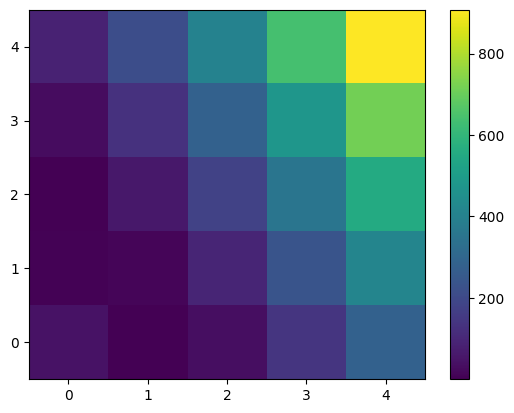

In [13]:
plt.imshow(result[3], cmap='viridis', interpolation='nearest', origin='lower', aspect='auto')
plt.colorbar()
plt.show()

In [14]:
result[0]

array([0.0001   , 0.0002575])

In [15]:
result[3]

array([[4.60186613e+01, 4.55125949e-02, 3.35899382e+01, 1.39814560e+02,
        2.81098400e+02],
       [6.02759217e+00, 1.36632704e+01, 9.41162281e+01, 2.34857130e+02,
        4.12217866e+02],
       [1.99007888e+00, 5.84143474e+01, 1.77378044e+02, 3.51891556e+02,
        5.53621864e+02],
       [2.86998406e+01, 1.30220990e+02, 2.82445461e+02, 4.78165928e+02,
        7.13990112e+02],
       [8.82353749e+01, 2.16101335e+02, 4.04007985e+02, 6.38594195e+02,
        9.07942653e+02]])

In [16]:
rates = get_rates_from_models(result[0])
strokeRates = rates["stroke"]
dementiaRates = rates["dementia"]
miRates = rates["mi"]
deathRates = rates["death"]

In [17]:
print("     Group     Reference     Simulation")
for outcome in rates.keys():
    print(f"{outcome:>10}" +
        f"{ratesRef[outcome]:>14.1f} " + 
          f"{rates[outcome]:>14.1f}")

     Group     Reference     Simulation
    stroke          12.0           11.9
  dementia          11.0           10.6
     death          27.0           26.8
        mi          12.0           11.6


In [ ]:
##uncomment ascvd line!!!